In [1]:
# Basics
import os
import sys
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm
from ssms.basic_simulators import simulator

import pymc as pm

# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
# pytensor.config.floatX = "float32"

%matplotlib inline
%config InlineBackend.figure_format='retina'

print(hssm.__version__)

/var/folders/cy/4xdvhqx966nggmk95hsnyzc40000gn/T/ipykernel_7400/1034461199.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.2.0


In [2]:
from hssm.distribution_utils import (
    make_distribution,  # A general function for making Distribution classes
    make_distribution_from_onnx,  # Makes Distribution classes from onnx files
    make_distribution_from_blackbox,  # Makes Distribution classes from callables
)

# pm.Distributions that represents the top-level distribution for
# DDM models (the Wiener First-Passage Time distribution)
from hssm.likelihoods import logp_ddm_sdv, DDM

In [34]:
data = pd.read_csv(
    "/Users/corrado/_repositories/memory_surprise/data/prep/memory/memory_surprise_input_for_hddmrl.csv"
)

# Modifying 'response' column
data['response'] = np.where(data['response'] == 1, 1, -1)

data.head()

,subj_idx,response,participant_code,is_self,is_surprise,condition,rt
0,1,1,al_mi_1997_06_11_513_f,SELF,NOSURPRISE,CE,1.419
1,1,1,al_mi_1997_06_11_513_f,SELF,NOSURPRISE,CE,1.069
2,1,1,al_mi_1997_06_11_513_f,SELF,NOSURPRISE,CE,0.741
3,1,1,al_mi_1997_06_11_513_f,SELF,NOSURPRISE,CE,0.806
4,1,1,al_mi_1997_06_11_513_f,SELF,NOSURPRISE,CE,0.752


In [35]:
data.size

28000

In [36]:
print(data['participant_code'].unique())

['al_mi_1997_06_11_513_f' 'an_ta_1995_12_26_945_m'
 'an_va_1980_03_27_372_m' 'ba_ne_1975_03_06_530_f'
 'el_ag_1999_12_28_589_f' 'el_ba_1972_08_18_572_f'
 'fr_pi_1996_06_22_986_m' 'fr_se_1996_05_03_823_m'
 'gi_po_1996_06_20_884_m' 'il_to_1998_03_07_824_f'
 'le_ma_1992_11_25_775_f' 'li_ch_1970_01_27_367_f'
 'ma_an_1999_05_26_962_f' 'ma_ar_1997_03_04_911_f'
 'ma_po_1969_05_24_201_m' 'ma_ro_1996_03_26_97_m' 'mi_de_1996_04_26_459_m'
 'ni_vi_1995_10_03_417_m' 'st_ce_1960_04_23_403_f'
 'va_ru_2001_12_12_351_f']


In [37]:
num_subjects = data['participant_code'].nunique()
print(f"Numero di soggetti unici: {num_subjects}")

Numero di soggetti unici: 20


In [38]:
print(data['participant_code'].value_counts())

participant_code
al_mi_1997_06_11_513_f    200
an_ta_1995_12_26_945_m    200
st_ce_1960_04_23_403_f    200
ni_vi_1995_10_03_417_m    200
mi_de_1996_04_26_459_m    200
ma_ro_1996_03_26_97_m     200
ma_po_1969_05_24_201_m    200
ma_ar_1997_03_04_911_f    200
ma_an_1999_05_26_962_f    200
li_ch_1970_01_27_367_f    200
le_ma_1992_11_25_775_f    200
il_to_1998_03_07_824_f    200
gi_po_1996_06_20_884_m    200
fr_se_1996_05_03_823_m    200
fr_pi_1996_06_22_986_m    200
el_ba_1972_08_18_572_f    200
el_ag_1999_12_28_589_f    200
ba_ne_1975_03_06_530_f    200
an_va_1980_03_27_372_m    200
va_ru_2001_12_12_351_f    200
Name: count, dtype: int64


In [39]:
# C (Control, no-surprise) S (Surprise)
# E (Ego, self) O (Other)

condition_mapping = data.groupby("condition")[["is_self", "is_surprise"]].agg(lambda x: x.unique())
print(condition_mapping)

              is_self   is_surprise
condition                          
CE             [SELF]  [NOSURPRISE]
CO         [STRANGER]  [NOSURPRISE]
SE             [SELF]    [SURPRISE]
SO         [STRANGER]    [SURPRISE]


In [10]:
print(data['condition'].unique())

['CE' 'CO' 'SE' 'SO']


In [40]:
condition_counts = data.groupby(["condition", "is_self", "is_surprise"]).size().reset_index(name="count")
print(condition_counts)

  condition   is_self is_surprise  count
0        CE      SELF  NOSURPRISE   1000
1        CO  STRANGER  NOSURPRISE   1000
2        SE      SELF    SURPRISE   1000
3        SO  STRANGER    SURPRISE   1000


In [42]:
# Calcolare media e mediana dei tempi di reazione (RT) per ogni condizione
rt_stats = data.groupby("condition")["rt"].agg(["mean", "median"]).reset_index()
print(rt_stats)

  condition      mean    median
0        CE  1.580747  1.549000
1        CO  1.550856  1.545281
2        SE  1.613956  1.585771
3        SO  1.631092  1.613502


In [14]:
df = pd.get_dummies(data, columns=['condition'])
df.head()

,subj_idx,response,participant_code,is_self,is_surprise,rt,condition_CE,condition_CO,condition_SE,condition_SO
0,1,1,al_mi_1997_06_11_513_f,SELF,NOSURPRISE,1.419,True,False,False,False
1,1,1,al_mi_1997_06_11_513_f,SELF,NOSURPRISE,1.069,True,False,False,False
2,1,1,al_mi_1997_06_11_513_f,SELF,NOSURPRISE,0.741,True,False,False,False
3,1,1,al_mi_1997_06_11_513_f,SELF,NOSURPRISE,0.806,True,False,False,False
4,1,1,al_mi_1997_06_11_513_f,SELF,NOSURPRISE,0.752,True,False,False,False


In [13]:
# df = data.astype('float32')

In [29]:
model_reg = hssm.HSSM(
    data=data,
    include=[
        {
            "name": "v",  # Drift rate dipendente da condition
            "prior": {
                "condition": {"name": "Normal", "mu": 0.0, "sigma": 0.5},  # Priors più stretti per stabilizzare
            },
            "formula": "v ~ 0 + condition + (1 | subj_idx)",
            "link": "identity",
        },
        {
            "name": "t",  # Non-decision time dipendente da condition
            "prior": {
                "condition": {"name": "Normal", "mu": 0.3, "sigma": 0.05},  # Priors più stretti
            },
            "formula": "t ~ 0 + condition + (1 | subj_idx)",
            "link": "identity",
        },
        {
            "name": "a",  # Decision threshold dipendente da condition
            "prior": {
                "condition": {"name": "Normal", "mu": 2.0, "sigma": 0.2},  # Priors più stretti per ridurre varianza
            },
            "formula": "a ~ 0 + condition + (1 | subj_idx)",
            "link": "identity",
        }
    ],
)


In [43]:
model_reg = hssm.HSSM(
    data=data,
    include=[
        {
            "name": "v",  # Drift rate dipendente da condition
            "prior": {
                "condition": {"name": "Normal", "mu": 0.0, "sigma": 0.5},  # Priors più stretti per stabilizzare
            },
            "formula": "v ~ 0 + condition + (1 | subj_idx)",
            "link": "identity",
        }
    ],
)


In [44]:
model_reg

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 4000

Parameters:

v:
    Formula: v ~ 0 + condition + (1 | subj_idx)
    Priors:
        v_condition ~ Normal(mu: 0.0, sigma: 0.5)
        v_1|subj_idx ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))
    Link: identity
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.1)
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

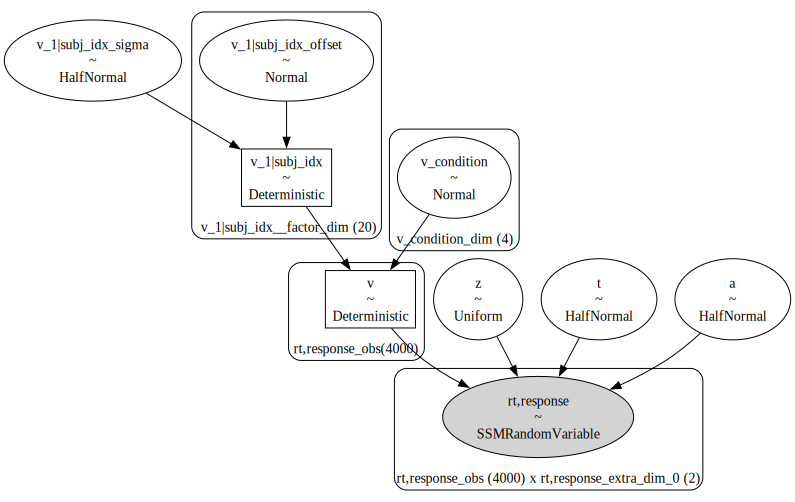

In [45]:
model_reg.graph()

In [46]:
infer_data_reg = model_reg.sample(
    sampler="nuts_numpyro", chains=4, cores=8, draws=2000, tune=1000
)

Compiling...
Compilation time = 0:00:05.770297
Sampling...
Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]







Running chain 0:   5%|▌         | 150/3000 [00:26<06:57,  6.82it/s]


Running chain 0:  10%|█         | 300/3000 [00:52<07:21,  6.11it/s]


Running chain 0:  15%|█▌        | 450/3000 [01:20<07:22,  5.76it/s]





Running chain 0:  25%|██▌       | 750/3000 [02:25<07:13,  5.19it/s]



In [15]:
az.plot_trace(model_reg.traces, combined=True)
plt.tight_layout()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1065d0e10>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
# az.summary(infer_data_reg)

In [ ]:
# Selezioniamo solo i parametri globali importanti
params_of_interest = ["v_condition"]

# Filtriamo la traccia per includere solo questi parametri
out = az.summary(infer_data_reg, var_names=params_of_interest)
print(out)

In [33]:
# Selezioniamo solo i parametri globali importanti
params_of_interest = ["v_condition", "t_condition", "a_condition"]

# Filtriamo la traccia per includere solo questi parametri
out = az.summary(infer_data_reg, var_names=params_of_interest)
print(out)

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
v_condition[CE] -0.163  0.586  -0.757    0.502      0.290    0.222       4.0   
v_condition[CO]  0.312  0.737  -0.936    0.887      0.368    0.282       4.0   
v_condition[SE]  0.266  0.559  -0.528    0.835      0.279    0.214       4.0   
v_condition[SO]  0.221  0.443  -0.398    0.819      0.220    0.169       4.0   
t_condition[CE] -0.149  0.377  -0.600    0.281      0.188    0.144       4.0   
t_condition[CO] -0.111  0.408  -0.661    0.352      0.204    0.156       4.0   
t_condition[SE] -0.054  0.510  -0.692    0.489      0.254    0.195       4.0   
t_condition[SO] -0.094  0.225  -0.348    0.261      0.112    0.086       4.0   
a_condition[CE]  1.819  0.357   1.464    2.394      0.178    0.137       4.0   
a_condition[CO]  1.663  0.177   1.387    1.832      0.088    0.068       4.0   
a_condition[SE]  1.829  0.458   1.231    2.321      0.228    0.175       4.0   
a_condition[SO]  1.546  0.365   1.188   

In [14]:
# Estrarre i campioni posteriori per v_condition
posterior_samples = infer_data_reg.posterior

# Controlliamo la struttura di v_condition
print(posterior_samples["v_condition"])

# Estrarre i valori del tensore: `chain`, `draw`, `condition_dim`
v_samples_array = posterior_samples["v_condition"].values  # Shape: (chains, draws, num_conditions)

# Otteniamo il numero di condizioni (terza dimensione del tensore)
num_conditions = v_samples_array.shape[2]  # Il numero di condizioni è la terza dimensione

# Definizione delle condizioni (assicurati che siano nell'ordine corretto)
conditions = ["CE", "CO", "SE", "SO"]

# Creiamo un dizionario con le distribuzioni di v per ciascuna condizione
# Dobbiamo appiattire tutte le dimensioni tranne l'ultima
v_samples = {conditions[i]: v_samples_array[:, :, i].flatten() for i in range(num_conditions)}

<xarray.DataArray 'v_condition' (chain: 4, draw: 1500, v_condition_dim: 4)>
array([[[-0.47873535,  0.42838009,  0.21491397,  0.61105971],
        [-0.47873535,  0.42838009,  0.21491397,  0.61105971],
        [-0.47873535,  0.42838009,  0.21491397,  0.61105971],
        ...,
        [-0.47873535,  0.42838009,  0.21491397,  0.61105971],
        [-0.47873535,  0.42838009,  0.21491397,  0.61105971],
        [-0.47873535,  0.42838009,  0.21491397,  0.61105971]],

       [[ 0.20751835,  0.8602624 ,  0.71989074, -0.19143445],
        [ 0.20751835,  0.8602624 ,  0.71989074, -0.19143445],
        [ 0.20751835,  0.8602624 ,  0.71989074, -0.19143445],
        ...,
        [ 0.20751835,  0.8602624 ,  0.71989074, -0.19143445],
        [ 0.20751835,  0.8602624 ,  0.71989074, -0.19143445],
        [ 0.20751835,  0.8602624 ,  0.71989074, -0.19143445]],

       [[ 0.55314381,  0.08176336, -0.48690846, -0.17925911],
        [ 0.55314381,  0.08176336, -0.48690846, -0.17925911],
        [ 0.55314381,  0.0

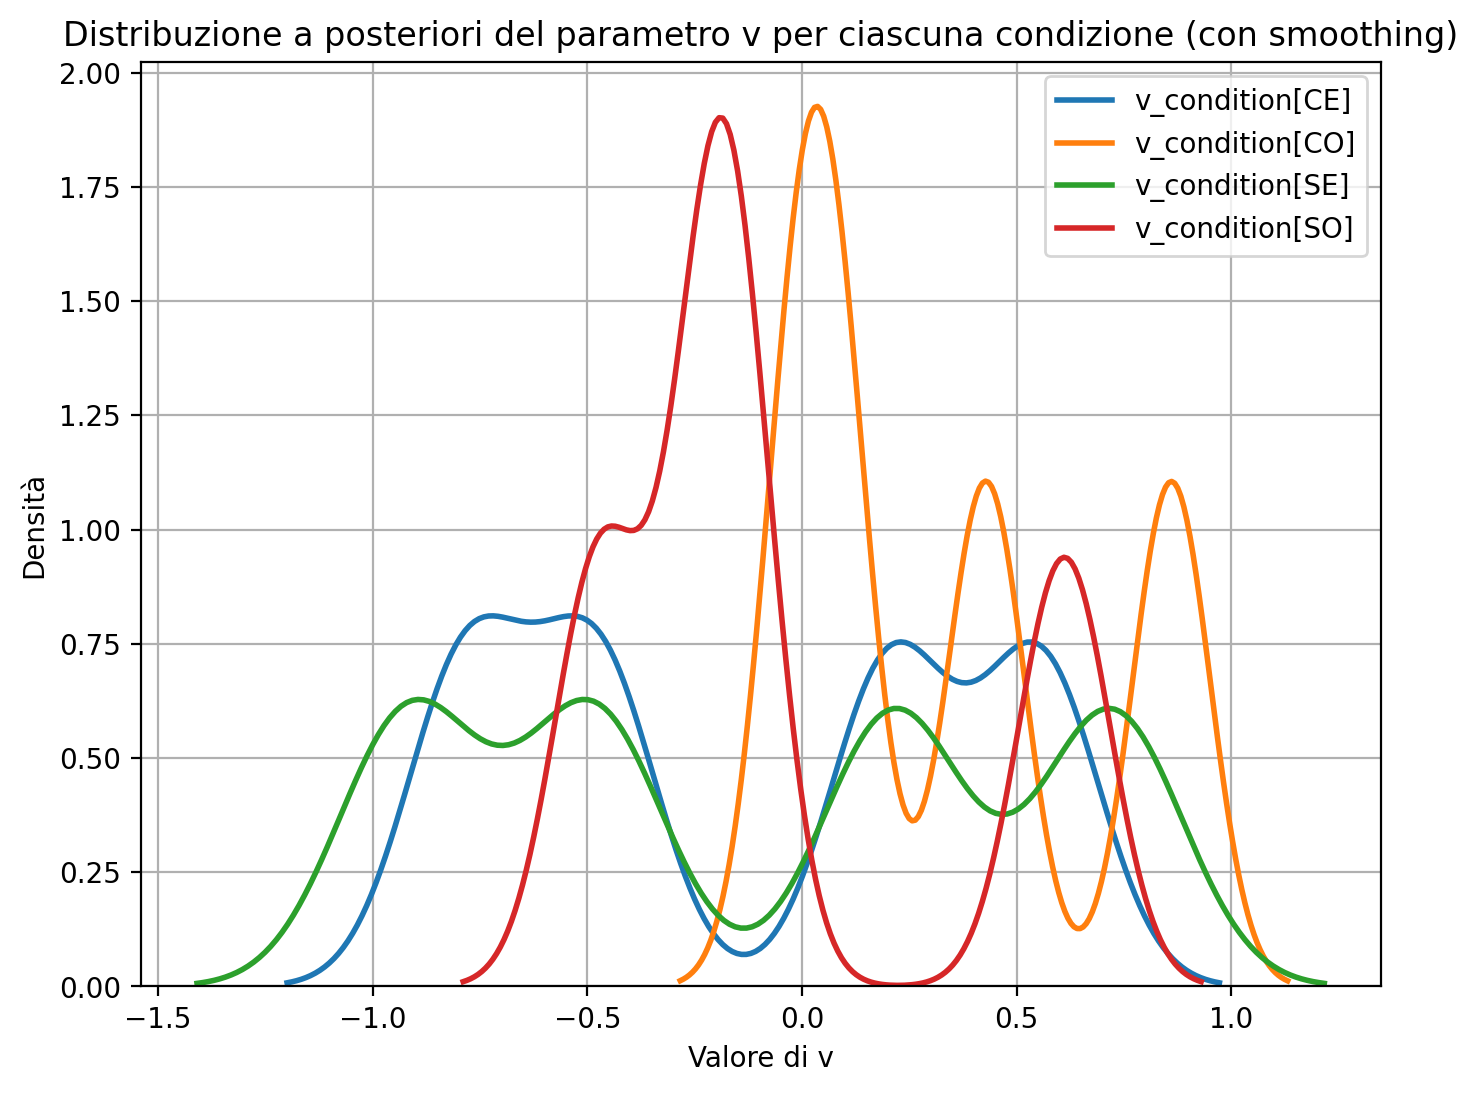

In [18]:
# Creare il grafico con seaborn per mostrare le distribuzioni a posteriori con maggiore smoothing
plt.figure(figsize=(8, 6))

for cond, samples in v_samples.items():
    sns.kdeplot(samples, label=f"v_condition[{cond}]", linewidth=2, bw_adjust=1.5)  # Maggiore smoothing

# Miglioramenti grafici
plt.xlabel("Valore di v")
plt.ylabel("Densità")
plt.title("Distribuzione a posteriori del parametro v per ciascuna condizione (con smoothing)")
plt.legend()
plt.grid(True)

# Mostrare il grafico
plt.show()



/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/anaconda3/envs/hssm_env/lib/python3.11/site-

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

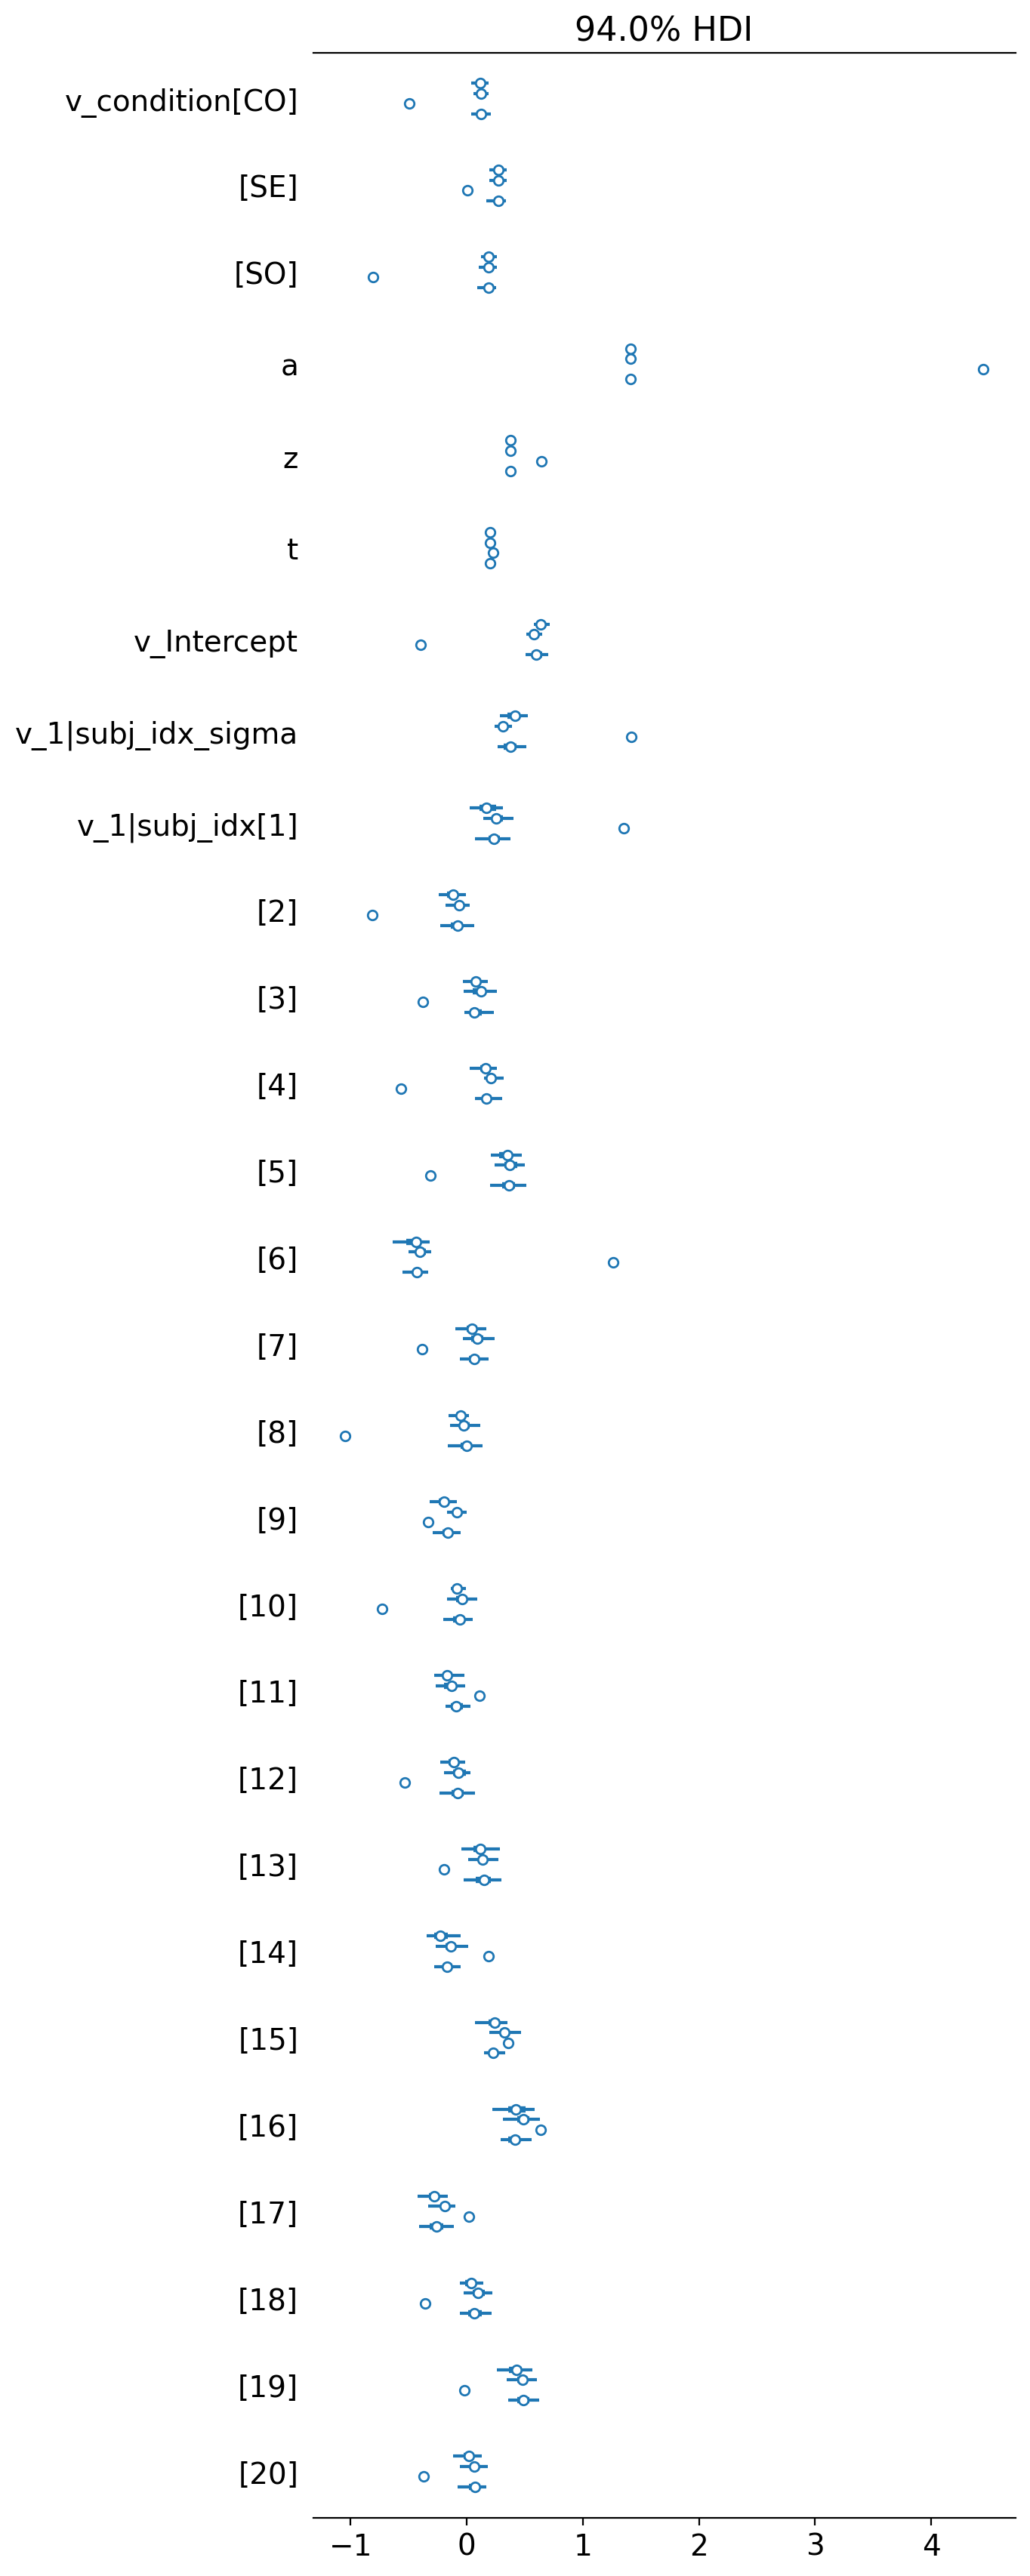

In [21]:
az.plot_forest(model_reg.traces)

In [47]:
df = data[["subj_idx", "condition", "rt", "response"]]
df.head()

,subj_idx,condition,rt,response
0,1,CE,2.709,1
1,1,CE,1.958,1
2,1,CE,3.000,-1
3,1,CE,1.873,1
4,1,CE,1.624,-1


In [36]:
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.2, 0.5]

obs_ddm_pymc = simulator([v_true, a_true, z_true, t_true], model="ddm", n_samples=1000)

dataset_pymc = pd.DataFrame(
    np.column_stack([obs_ddm_pymc["rts"][:, 0], obs_ddm_pymc["choices"][:, 0]]),
    columns=["rt", "response"],
)

TypeError: 'module' object is not callable

# This works best

In [12]:
data.head

<bound method NDFrame.head of       subj_idx  response        participant_code   is_self is_surprise  \
0            1         1  al_mi_1997_06_11_513_f      SELF  NOSURPRISE   
1            1         1  al_mi_1997_06_11_513_f      SELF  NOSURPRISE   
2            1         1  al_mi_1997_06_11_513_f      SELF  NOSURPRISE   
3            1         1  al_mi_1997_06_11_513_f      SELF  NOSURPRISE   
4            1         1  al_mi_1997_06_11_513_f      SELF  NOSURPRISE   
...        ...       ...                     ...       ...         ...   
3995        20         1  va_ru_2001_12_12_351_f  STRANGER    SURPRISE   
3996        20         1  va_ru_2001_12_12_351_f  STRANGER    SURPRISE   
3997        20         1  va_ru_2001_12_12_351_f  STRANGER    SURPRISE   
3998        20         1  va_ru_2001_12_12_351_f  STRANGER    SURPRISE   
3999        20         1  va_ru_2001_12_12_351_f  STRANGER    SURPRISE   

     condition        rt  
0           CE  1.419000  
1           CE  1.069000  


In [13]:
model_reg_v_angle_hier = hssm.HSSM(
    data=data,
    model="angle",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -2.0,
                    "upper": 2.0,
                    "initval": 0.0,
                },
            },
            "formula": "v ~ 0 + condition + (1 | participant_code)",
            "link": "identity",
        }
    ],
)

In [1]:
model_reg_v_angle_hier = hssm.HSSM(
    data=data,
    include=[
        {
            "name": "v",
            "prior": {  # NON serve specificare un prior per Intercept perché non c'è più
                "condition": {
                    "name": "Normal",
                    "mu": 0.0,
                    "sigma": 1.0,
                }
            },
            "formula": "v ~ 0 + condition + (1 | participant_code)",  # Modello corretto
            "link": "identity",
        }
    ],
)

NameError: name 'hssm' is not defined

In [14]:
infer_data_reg_v = model_reg_v_angle_hier.sample(
    sampler="nuts_numpyro", chains=2, cores=8, draws=1500, tune=500
)

Compiling...
Compilation time = 0:00:02.656523
Sampling...
Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]

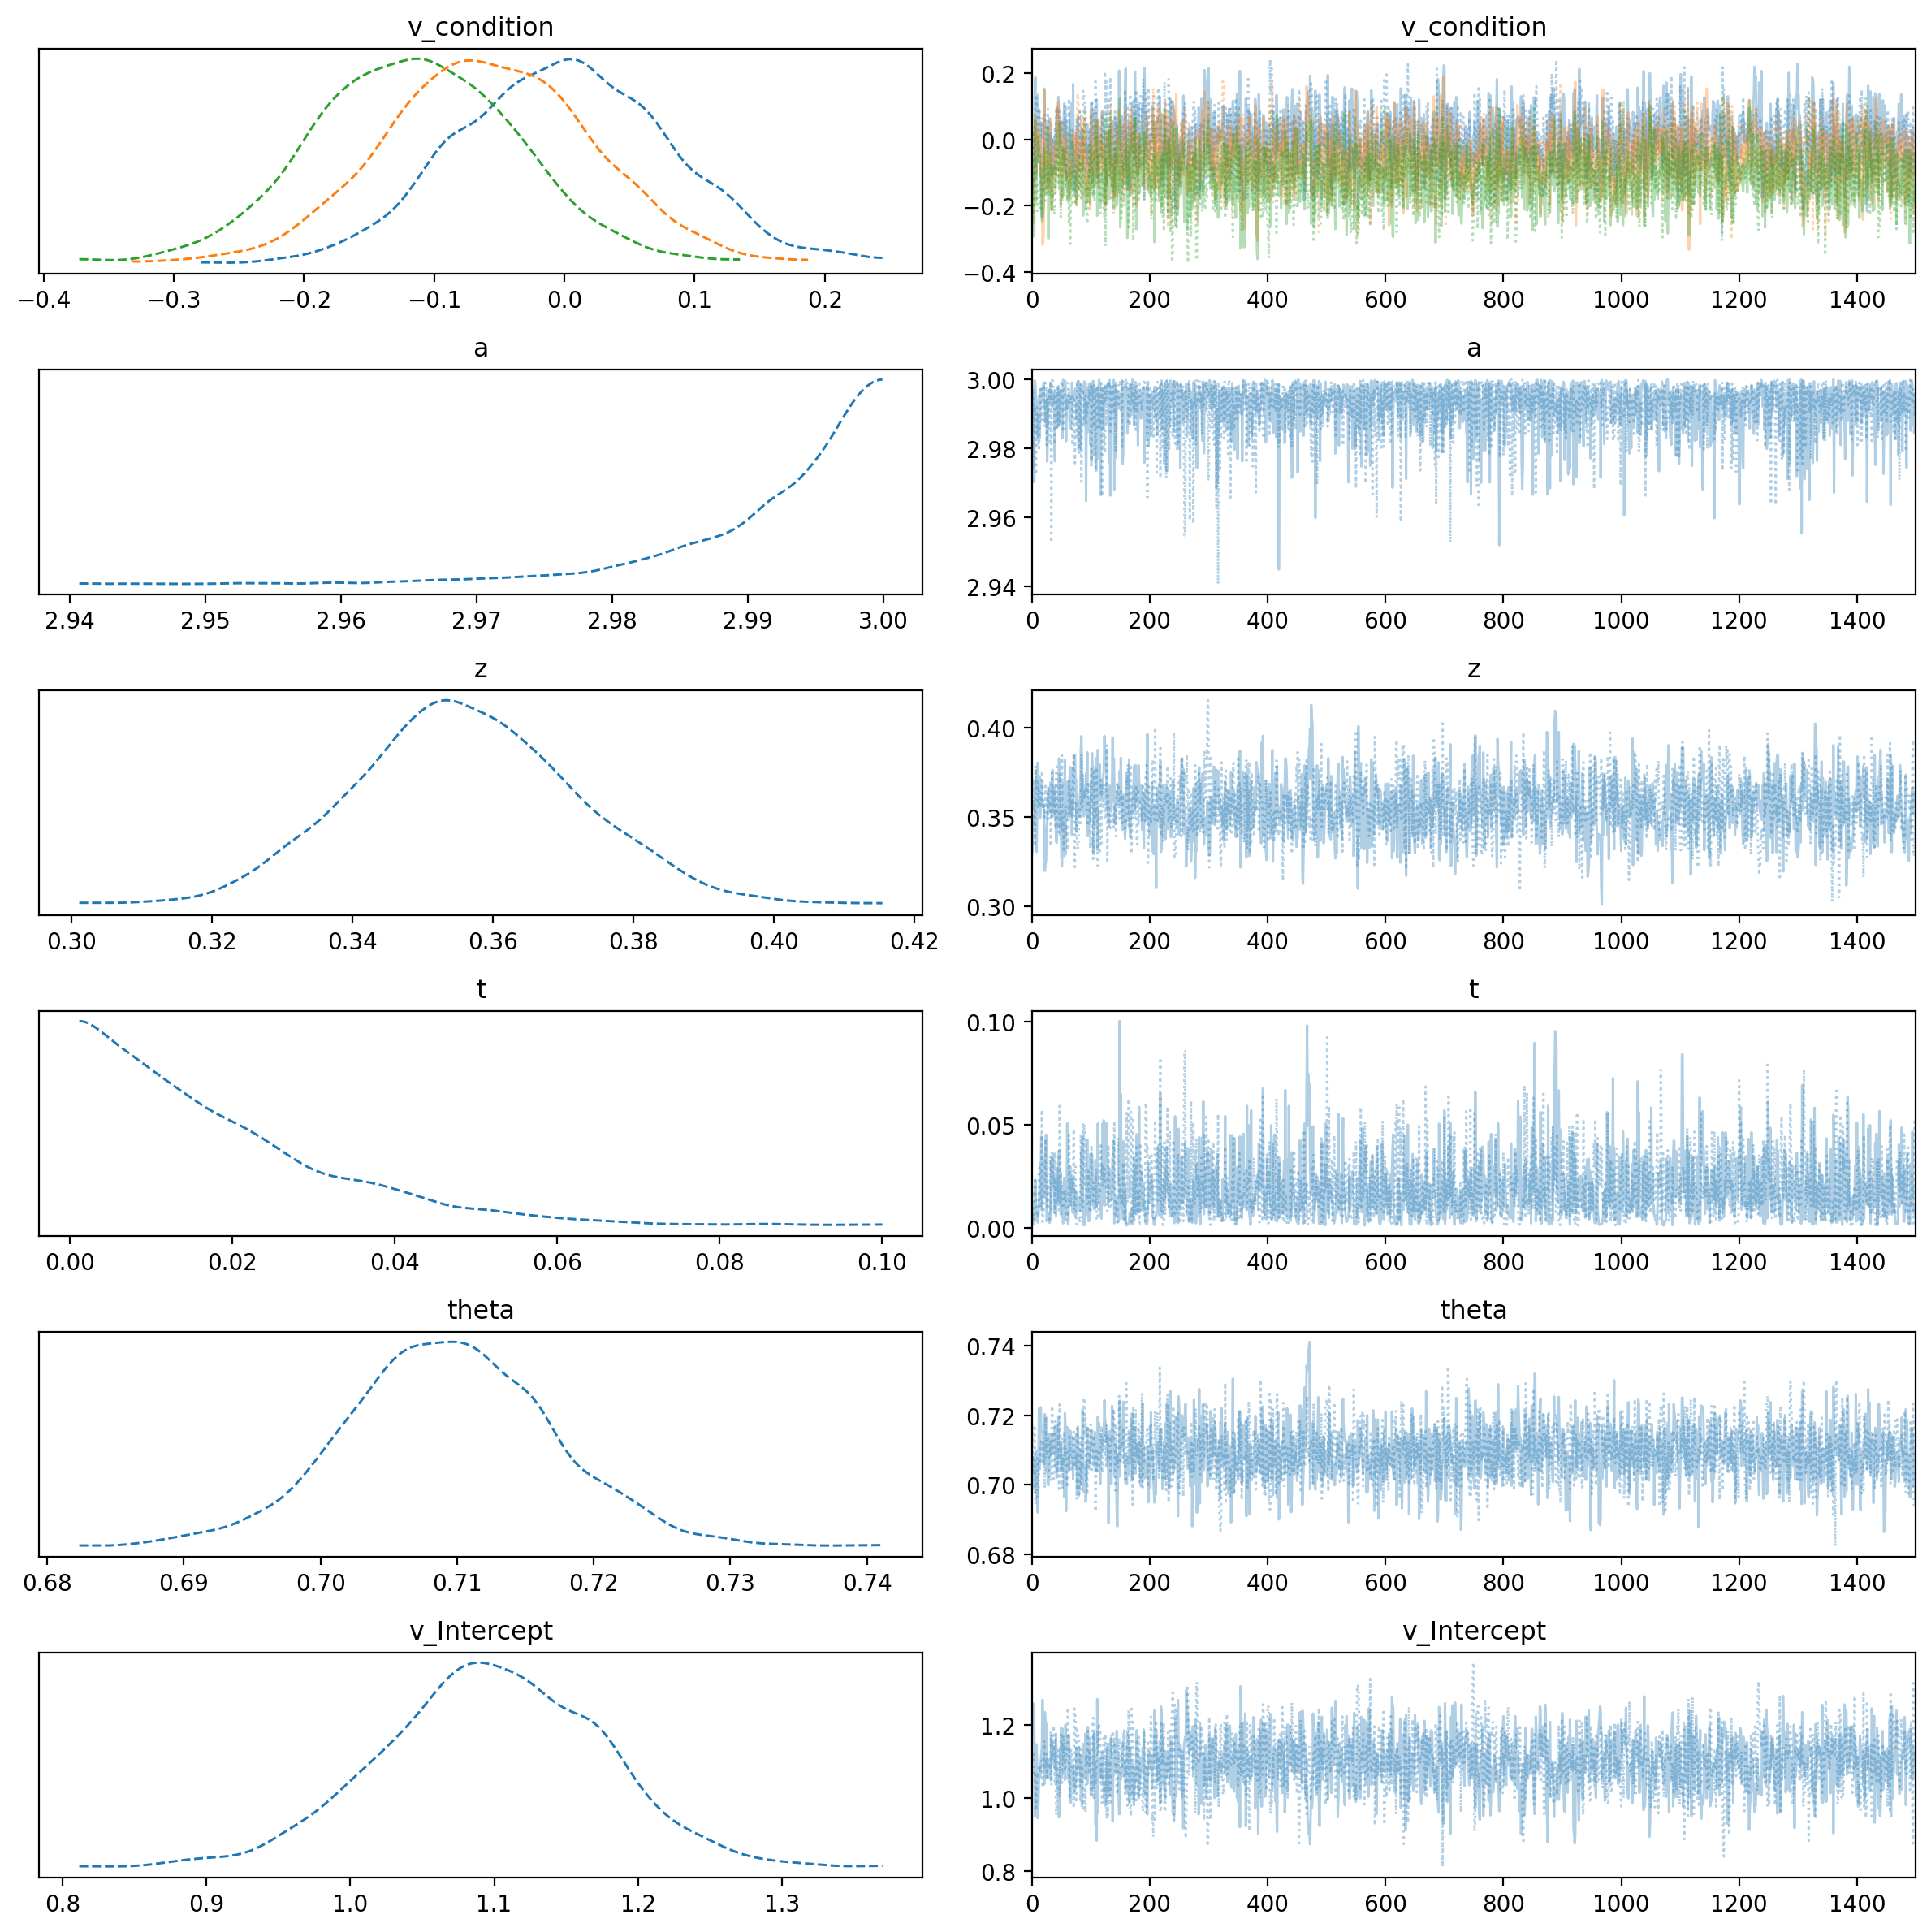

In [72]:
az.plot_trace(infer_data_reg_v, combined=True)
plt.tight_layout()

/Users/corrado/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/Users/corrado/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/Users/corrado/opt/anaconda3/envs/hssm_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/Users/

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

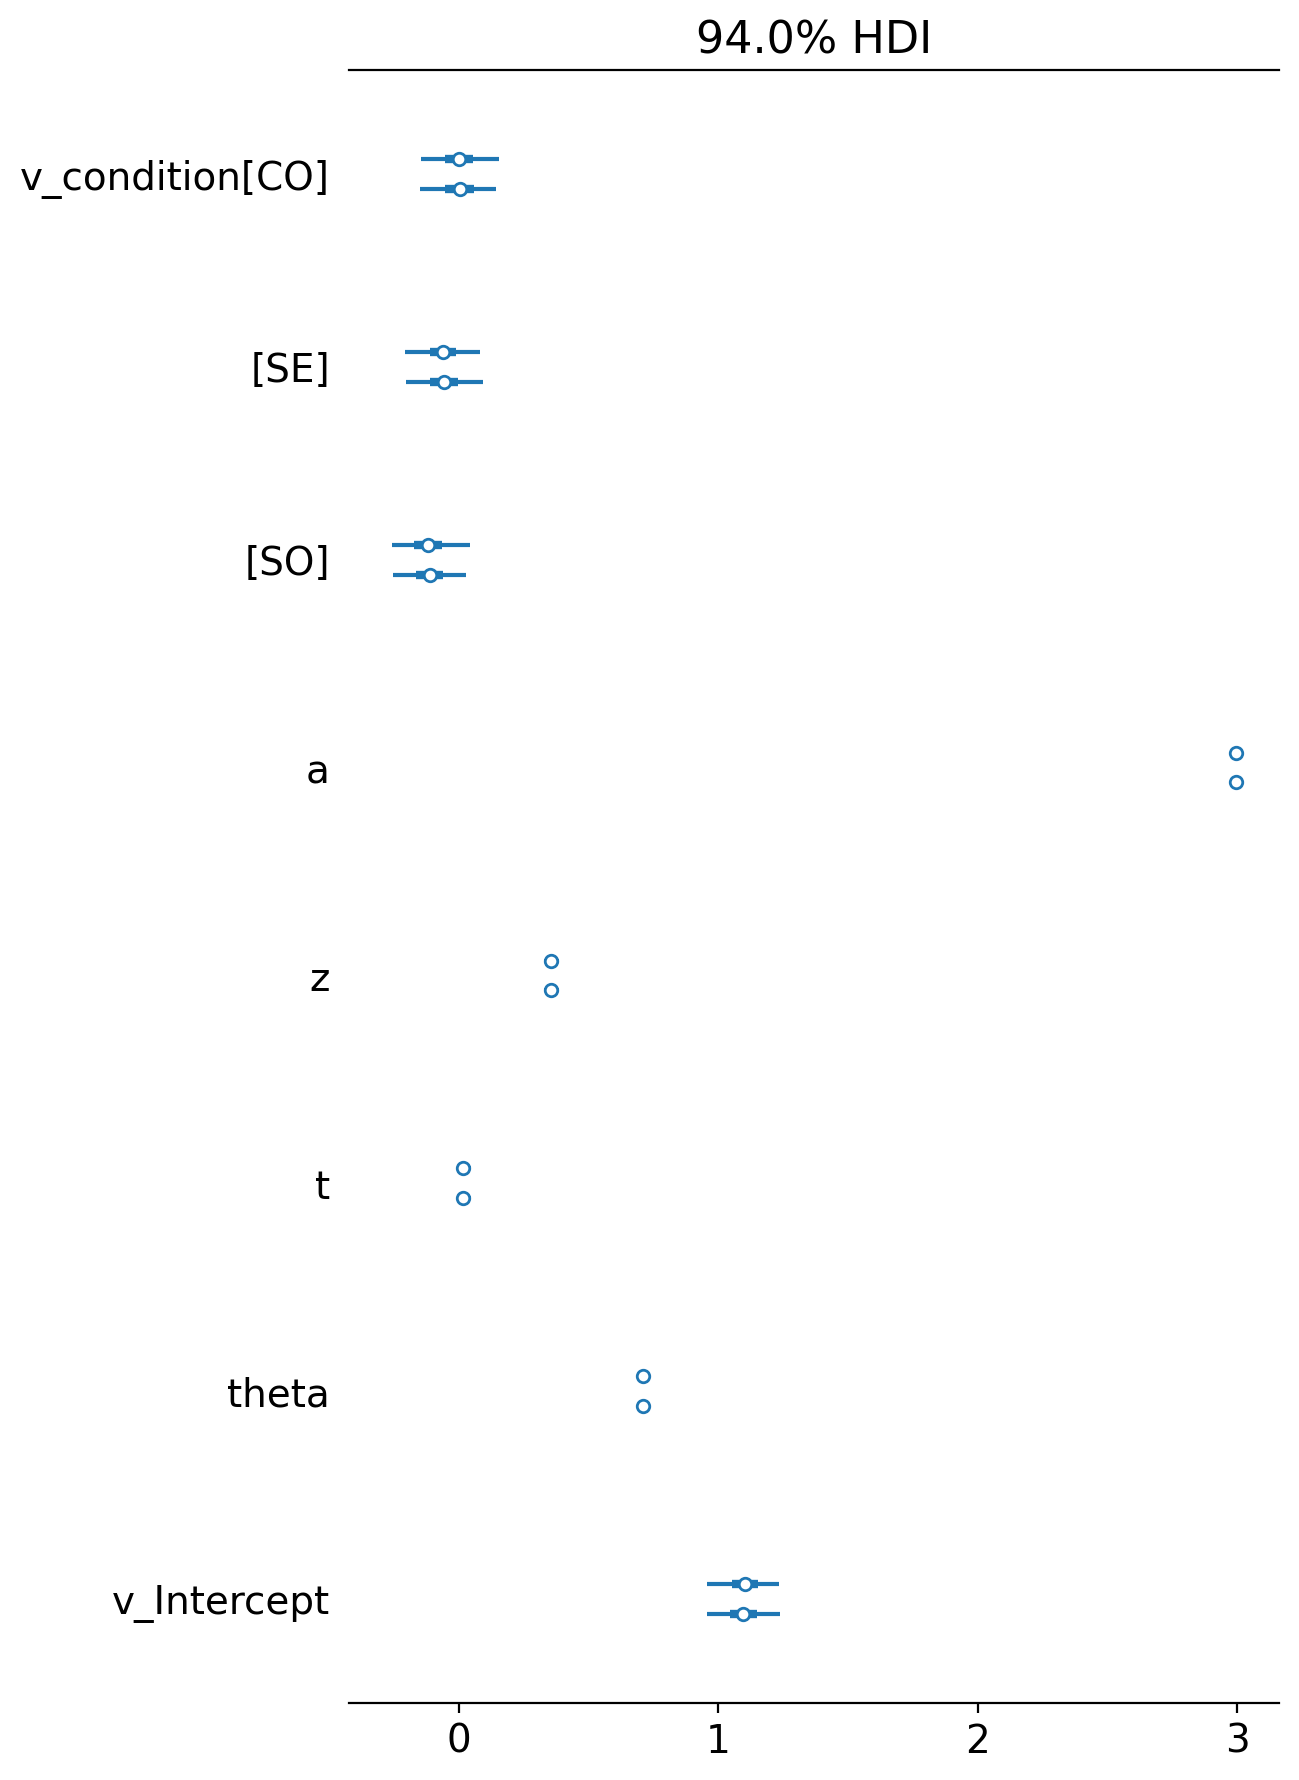

In [73]:
az.plot_forest(infer_data_reg_v)
